In [ ]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import hashlib
from sklearn.linear_model import LinearRegression
from google.colab.data_table import DataTable
from sklearn.metrics import r2_score
DataTable.max_columns = 50
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
file_path1 = '/content/drive/My Drive/breast_cancer_data.xlsx'
file_path2 = '/content/drive/My Drive/breast_cancer_data_2.xlsx'
file_path3 = '/content/drive/My Drive/breast_cancer_data_tnm.csv'
file_path4 = '/content/drive/My Drive/breast_cancer_data_tnm_2.csv'


In [ ]:
## PART 1: LOADING, INSPECTION, FIRST PROCESSING AND MERGING OF
##  -breast_cancer_data.xlsx, breast_cancer_data_2.xlsx,
##  -breast_cancer_data_tnm.csv and breast_cancer_data_tnm_2.csv

#breast_cancer_data.xlsx, breast_cancer_data_2.xlsx
df_bcd_s1 = pd.concat((map(pd.read_excel, [file_path1, file_path2])))
print(df_bcd_s1.head())
print(df_bcd_s1.shape)
print(df_bcd_s1.dtypes)
print(df_bcd_s1.isnull().sum())
print(df_bcd_s1.describe())

# Unnamed: 0 is an alphabetic incremental coding for instances, completely unuseful for our purposes. We are going to delete it
df_bcd_s1.drop('Unnamed: 0', axis=1, inplace=True)

# Side is a textual variable that is almost completely empty. We are going to delete it, as it doesn't contain almost any
# potentially useful information, nor his values can be used to extrapolate the rest of missing values
df_bcd_s1.drop('side', axis=1, inplace=True)

#If we have some duplicated instances, we are going to delete then
df_bcd_s1=df_bcd_s1.drop_duplicates()

  Unnamed: 0   ehr side neoadjuvant  grade  invasive  er_positive  \
0         AA  6849  NaN          no    1.0       1.0          1.0   
1         AB   268  NaN          no    NaN       1.0          1.0   
2         AC  1458  NaN          no    1.0       1.0          1.0   
3         AD   268  NaN          no    NaN       1.0          1.0   
4         AE  2013  NaN         yes    3.0       1.0          1.0   

   pr_positive  her2_positive  ki67  ... diagnosis_date death_date  \
0          1.0            1.0   NaN  ...     2016-08-23        NaN   
1          1.0            0.0   NaN  ...     2015-09-05        NaN   
2          1.0            0.0   0.0  ...     2017-03-01        NaN   
3          1.0            0.0   NaN  ...     2015-09-05        NaN   
4          1.0            1.0  17.0  ...     2014-08-31        NaN   

  recurrence_year  menarche_age  menopause_age  pregnancy  abort  birth  \
0             NaN          17.0           51.0        2.0    0.0      2   
1             

In [ ]:
#second file
#breast_cancer_data_tnm.csv, breast_cancer_data_tnm_2.csv
df_bcd_s2 = pd.concat(map(pd.read_csv, (file_path3, file_path4)), ignore_index=True)
print(df_bcd_s2.head())
print(df_bcd_s2.shape)
print(df_bcd_s2.dtypes)
print(df_bcd_s2.isnull().sum())
print(df_bcd_s2.describe())

#remove cases of multiple tumors within df_bcd_s2
df_bcd_s2_filter=df_bcd_s2['ehr']
df_bcd_s2_filter= df_bcd_s2_filter[df_bcd_s2_filter.duplicated()]
df_bcd_s2 = df_bcd_s2.drop(df_bcd_s2[df_bcd_s2['ehr'].isin(df_bcd_s2_filter)].index)
print(df_bcd_s2.shape)

# merging of both dataframes, using an inner join (taking only ehr's that are present in both types of datasets). If there are ehr's
# that are present in one dataset but not in the other, we are not going to take that in consideration.
df_bcd = pd.merge(left=df_bcd_s1,right=df_bcd_s2, how='inner', left_on='ehr', right_on='ehr')
print(df_bcd.head())

# some preliminary descriptive analysis.
print(df_bcd.shape)
print(df_bcd.dtypes)
print(df_bcd.isnull().sum())
print(df_bcd.describe())
display(df_bcd)


    ehr  n_tumor  t    n    m t_after_neoadj  n_after_neoadj  m_after_neoadj
0  6849        1  1  0.0  0.0            NaN             NaN             NaN
1  6849        3  2  0.0  0.0            NaN             NaN             NaN
2   268        1  1  0.0  0.0            NaN             NaN             NaN
3   268        2  1  1.0  0.0            NaN             NaN             NaN
4   268        3  2  0.0  0.0            NaN             NaN             NaN
(236, 8)
ehr                 int64
n_tumor             int64
t                  object
n                  object
m                 float64
t_after_neoadj     object
n_after_neoadj    float64
m_after_neoadj    float64
dtype: object
ehr                 0
n_tumor             0
t                   4
n                   6
m                   4
t_after_neoadj    204
n_after_neoadj    204
m_after_neoadj    204
dtype: int64
               ehr     n_tumor           m  n_after_neoadj  m_after_neoadj
count   236.000000  236.000000  232.000000 

,ehr,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,birth_date,diagnosis_date,...,birth,caesarean,hist_type,n_tumor,t,n,m,t_after_neoadj,n_after_neoadj,m_after_neoadj
0,2013,yes,3.0,1.0,1.0,1.0,1.0,17.0,1977-08-19,2014-08-31,...,-1,NaN,ductal,1,2,1.0,1.0,1,2.0,0.0
1,1350,no,2.0,1.0,0.0,1.0,0.0,44.0,1951-04-02,2003-05-24,...,3,NaN,ductal,1,1,0.0,0.0,NaN,NaN,NaN
2,5850,no,1.0,1.0,1.0,1.0,0.0,10.0,1958-11-12,2020-09-05,...,2,NaN,unknown,1,1,0.0,0.0,NaN,NaN,NaN
3,2470,no,2.0,1.0,1.0,0.0,0.0,0.0,1941-12-06,2016-01-12,...,-1,NaN,lobular,1,0,0.0,0.0,NaN,NaN,NaN
4,5380,no,1.0,1.0,1.0,1.0,0.0,20.0,1953-04-15,2012-12-02,...,-1,NaN,unknown,1,1,1.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,6647,yes,NaN,1.0,1.0,1.0,0.0,NaN,1984-01-29,2014-05-22,...,-1,NaN,ductal,1,NaN,NaN,NaN,2.0,2.0,0.0
221,768,no,NaN,NaN,1.0,1.0,0.0,NaN,1953-03-12,1997-10-25,...,-1,NaN,unknown,1,X,X,1.0,NaN,NaN,NaN
222,4534,no,NaN,1.0,NaN,NaN,0.0,NaN,1959-06-25,2003-11-10,...,2,NaN,ductal,1,2,0,0.0,NaN,NaN,NaN
223,7062,no,NaN,1.0,1.0,1.0,0.0,0.0,1971-03-21,2020-11-07,...,-1,NaN,ductal,1,1,0,0.0,NaN,NaN,NaN


In [ ]:
## PART 2: PROCESSING EHR/DATES

# Expressing information contained in dates as numbers provides us data that can be used more easily as an input in m-l algorithms.
# Anonymization is a main issue when working with health records.
# Malitious agents can recover sensitive information about patients using variables as ehr or relevant dates.
# So it is a good practice to delete sensitive data once extracted relevant information in a way preventing that possibility.

# Transform birth_date, diagnosis_date and death_date to datetimes.
df_bcd['birth_date'] = pd.to_datetime(df_bcd['birth_date'])
df_bcd['diagnosis_date'] = pd.to_datetime(df_bcd['diagnosis_date'])
df_bcd['death_date'] = pd.to_datetime(df_bcd['death_date'])

# Analyze diagnosis_date, birth_date and death_date. If there are instances with not feasible dates (for example, in the future) we
# are going to supress them, as they could be noisy instances. We are going to use 12-01-2022 as reference date
df_d = df_bcd[(pd.to_datetime(df_bcd['diagnosis_date'])> "2022-11")].index
df_de = df_bcd[(pd.to_datetime(df_bcd['death_date'])> "2022-11")].index
df_b = df_bcd[(pd.to_datetime(df_bcd['birth_date'])> "2022-11")].index
# We get this kind of abnormality for some diagnosis dates.
df_bcd.drop(df_d , inplace=True)
print(df_bcd.shape)

# For EHR's, we are going to hash values, ensuring then that original ones can't be recovered.
# repr(val).encode() -> The reason for this is that methods like md5 uses to accept only binary inputs.
df_bcd['h_ehr'] = [hashlib.md5(repr(val).encode()).hexdigest() for val in df_bcd['ehr']]
df_bcd.drop('ehr', axis=1, inplace=True)
new_ehr=df_bcd.pop('h_ehr')
df_bcd.insert(0,'ehr',new_ehr)

# Check that, for all cases, diagnosis_date is earlier than death_date. If is not the case, we are going to flip both dates
# Transform new reordered variables to datetimes.
df_bcd['diagnosis_date_ro']=[df_bcd.iloc[i]['diagnosis_date'] if (df_bcd.iloc[i]['diagnosis_date']-df_bcd.iloc[i]['death_date'])/np.timedelta64(1,'Y')<0
                            or pd.isnull(df_bcd.iloc[i]['death_date'])==True  else df_bcd.iloc[i]['death_date'] for i in range(0,len(df_bcd))]
df_bcd['death_date_ro']=[df_bcd.iloc[i]['death_date'] if (df_bcd.iloc[i]['diagnosis_date']-df_bcd.iloc[i]['death_date'])/np.timedelta64(1,'Y')<0
                            or pd.isnull(df_bcd.iloc[i]['death_date']) else df_bcd.iloc[i]['diagnosis_date'] for i in range(0,len(df_bcd))]
df_bcd['diagnosis_date_ro'] = pd.to_datetime(df_bcd['diagnosis_date_ro'])
df_bcd['death_date_ro'] = pd.to_datetime(df_bcd['death_date_ro'])

# We are going to obtain approximate dates for recurrence_years.
# Consideration 1. If bdc_df.diagnosis_date.year and bcd_df.death_date.year are very close and
# there is also a recurrence_year value, we consider death date as the recurrence_date, in order to avoid setting this
# approximate date after death or before diagnosis. If is not the case, we  are going to consider 1th of June of the corresponding year as the approximate date
# Consideration 2. If it is any case in which recurrence_year is out of the bounds defined by diagnosis_date and death_date, we don't consider that value.
df_bcd['recurrence_date']=[datetime.date(int(df_bcd.iloc[i]['recurrence_year']),6,1) if (df_bcd.iloc[i].death_date_ro-df_bcd.iloc[i].diagnosis_date_ro)/np.timedelta64(1,'Y')>1
                           and (pd.isnull(df_bcd.iloc[i]['recurrence_year'])==False and pd.isnull(df_bcd.iloc[i]['death_date_ro'])==False)
                           or ((pd.isnull(df_bcd.iloc[i]['recurrence_year'])==False and pd.isnull(df_bcd.iloc[i]['death_date'])==True)) else df_bcd.iloc[i]['death_date_ro']
                           if pd.isnull(df_bcd.iloc[i]['recurrence_year'])==False
                           and pd.isnull(df_bcd.iloc[i]['death_date_ro'])==False
                           else np.datetime64('NaT') for i in range(0,len(df_bcd))]
df_bcd['recurrence_date'] =pd.to_datetime(df_bcd['recurrence_date'])
df_bcd['recurrence_date'] =[df_bcd.iloc[i]['recurrence_date'] if (df_bcd.iloc[i]['recurrence_date']-df_bcd.iloc[i]['death_date'])/np.timedelta64(1,'Y')<0
                            or pd.isnull(df_bcd.iloc[i]['death_date']) or (df_bcd.iloc[i]['recurrence_date']-df_bcd.iloc[i]['diagnosis_date'])/np.timedelta64(1,'Y')>0 else np.datetime64('NaT') for i in range(0,len(df_bcd))]

# create new fields for ages at diagnosis, death and possible relapse, containing the information expressed in the date fields.
df_bcd['age_at_diagnosis']=round((df_bcd.diagnosis_date_ro-df_bcd.birth_date)/np.timedelta64(1,'Y'),2)
df_bcd['age_at_death']=round((df_bcd.death_date_ro-df_bcd.birth_date)/np.timedelta64(1,'Y'),2)
df_bcd['age_at_relapse']=round((df_bcd.recurrence_date-df_bcd.birth_date)/np.timedelta64(1,'Y'),2)
df_bcd['current_age']=round((pd.to_datetime("today")-df_bcd.birth_date)/np.timedelta64(1,'Y'),2)
df_bcd['current_age']=[np.nan if pd.isnull(df_bcd.iloc[i]['age_at_death'])==False else df_bcd.iloc[i]['current_age'] for i in range(0,len(df_bcd))]

# create two binary variables: death_recorded and relapse_recorded
df_bcd['death_recorded']=[1 if pd.isnull(df_bcd.iloc[i]['age_at_death'])==False else 0 for i in range(0,len(df_bcd))]
df_bcd['relapse_recorded']=[1 if pd.isnull(df_bcd.iloc[i]['age_at_relapse'])==False else 0 for i in range(0,len(df_bcd))]

#finally, we delete the dates
df_bcd.drop('recurrence_date', axis=1, inplace=True)
df_bcd.drop('birth_date', axis=1, inplace=True)
df_bcd.drop('death_date', axis=1, inplace=True)
df_bcd.drop('diagnosis_date', axis=1, inplace=True)
df_bcd.drop('diagnosis_date_ro', axis=1, inplace=True)
df_bcd.drop('death_date_ro', axis=1, inplace=True)
df_bcd.drop('recurrence_year', axis=1, inplace=True)
print(df_bcd.head())
display(df_bcd)

(220, 26)
                                ehr neoadjuvant  grade  invasive  er_positive  \
0  8038da89e49ac5eabb489cfc6cea9fc1         yes    3.0       1.0          1.0   
1  861dc9bd7f4e7dd3cccd534d0ae2a2e9          no    2.0       1.0          0.0   
2  234a1273487bf7b2e2061b9b56373a29          no    1.0       1.0          1.0   
3  7cc234202e98d2722580858573fd0817          no    2.0       1.0          1.0   
4  b3dd760eb02d2e669c604f6b2f1e803f          no    1.0       1.0          1.0   

   pr_positive  her2_positive  ki67  menarche_age  menopause_age  ...    m  \
0          1.0            1.0  17.0           NaN            NaN  ...  1.0   
1          1.0            0.0  44.0          14.0            NaN  ...  0.0   
2          1.0            0.0  10.0          15.0           58.0  ...  0.0   
3          0.0            0.0   0.0          12.0            NaN  ...  0.0   
4          1.0            0.0  20.0          14.0           49.0  ...  0.0   

   t_after_neoadj  n_after_neoadj 

,ehr,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,menarche_age,menopause_age,...,m,t_after_neoadj,n_after_neoadj,m_after_neoadj,age_at_diagnosis,age_at_death,age_at_relapse,current_age,death_recorded,relapse_recorded
0,8038da89e49ac5eabb489cfc6cea9fc1,yes,3.0,1.0,1.0,1.0,1.0,17.0,NaN,NaN,...,1.0,1,2.0,0.0,37.06,NaN,NaN,46.79,0,0
1,861dc9bd7f4e7dd3cccd534d0ae2a2e9,no,2.0,1.0,0.0,1.0,0.0,44.0,14.0,NaN,...,0.0,NaN,NaN,NaN,52.18,71.16,NaN,NaN,1,0
2,234a1273487bf7b2e2061b9b56373a29,no,1.0,1.0,1.0,1.0,0.0,10.0,15.0,58.0,...,0.0,NaN,NaN,NaN,61.86,NaN,NaN,65.57,0,0
3,7cc234202e98d2722580858573fd0817,no,2.0,1.0,1.0,0.0,0.0,0.0,12.0,NaN,...,0.0,NaN,NaN,NaN,74.15,NaN,NaN,82.51,0,0
4,b3dd760eb02d2e669c604f6b2f1e803f,no,1.0,1.0,1.0,1.0,0.0,20.0,14.0,49.0,...,0.0,NaN,NaN,NaN,59.67,NaN,NaN,71.15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,8ce8b102d40392a688f8c04b3cd6cae0,yes,NaN,1.0,1.0,1.0,0.0,NaN,12.0,NaN,...,NaN,2.0,2.0,0.0,30.33,NaN,NaN,40.34,0,0
221,3a835d3215755c435ef4fe9965a3f2a0,no,NaN,NaN,1.0,1.0,0.0,NaN,13.0,NaN,...,1.0,NaN,NaN,NaN,44.65,NaN,57.26,71.24,0,1
222,72cad9e1f9ae79872b8d6ac34fc2851c,no,NaN,1.0,NaN,NaN,0.0,NaN,11.0,40.0,...,0.0,NaN,NaN,NaN,44.41,NaN,NaN,64.95,0,0
223,6cf75a28ed72a43ef7ca1b66ff345859,no,NaN,1.0,1.0,1.0,0.0,0.0,16.0,NaN,...,0.0,NaN,NaN,NaN,49.67,NaN,NaN,53.21,0,0


In [ ]:
## PART 3: PROCESSING DATATYPES OF CATEGORICAL VARIABLES

#First, we're going to analyze the different values we have for tumor classification.
print(df_bcd['t'].unique())
print(df_bcd['n'].unique())
print(df_bcd['m'].unique())

# We have seven valid values (0,1,2,3,4,X,IS).
# Transform this three variables into cathegorical ones, having six different levels
# First, we are going to replace floats by strings in df_bcd['n']
df_bcd['n']=df_bcd['n'].replace([0],'0')
df_bcd['n']=df_bcd['n'].replace([1.0],'1')
df_bcd['n']=df_bcd['n'].replace([2.0],'2')
df_bcd['n']=df_bcd['n'].replace([3.0],'3')
df_bcd['n']=df_bcd['n'].replace([2.0],'2')
df_bcd['m']=df_bcd['m'].replace([0.],'0')
df_bcd['m']=df_bcd['m'].replace([1.],'1')
print(df_bcd['n'].unique())
print(df_bcd['m'].unique())
# Then, we can aldeady procceed with datatype transformation
df_bcd['n'] = df_bcd.n.astype('category')
df_bcd['m'] = df_bcd.m.astype('category')
df_bcd['t'] = df_bcd.t.astype('category')
print(df_bcd.isnull().sum())

#The same, but with classification after neoadjuvant treatment
print(df_bcd['t_after_neoadj'].unique())
print(df_bcd['n_after_neoadj'].unique())
print(df_bcd['m_after_neoadj'].unique())
df_bcd['t_after_neoadj']=df_bcd['t_after_neoadj'].replace([0],'0')
df_bcd['t_after_neoadj']=df_bcd['t_after_neoadj'].replace([1.0],'1')
df_bcd['t_after_neoadj']=df_bcd['t_after_neoadj'].replace([2.0],'2')
df_bcd['n_after_neoadj']=df_bcd['n_after_neoadj'].replace([0],'0')
df_bcd['n_after_neoadj']=df_bcd['n_after_neoadj'].replace([1.0],'1')
df_bcd['n_after_neoadj']=df_bcd['n_after_neoadj'].replace([2.0],'2')
df_bcd['n_after_neoadj']=df_bcd['n_after_neoadj'].replace([3.0],'3')
df_bcd['m_after_neoadj']=df_bcd['m_after_neoadj'].replace([0],'0')
df_bcd['m_after_neoadj']=df_bcd['m_after_neoadj'].replace([1.0],'1')


#Categorical transformation and homogeneization for binary variables in breast_cancer_data.xlsx, breast_cancer_data_2.xlsx

# neoadjuvant
print(df_bcd['neoadjuvant'].unique())
df_bcd['neoadjuvant'] = df_bcd['neoadjuvant'].replace('yes', '1')
df_bcd['neoadjuvant'] = df_bcd['neoadjuvant'].replace('no', '0')
df_bcd['neoadjuvant'] = df_bcd.neoadjuvant.astype('category')

# invasive
print(df_bcd['invasive'].unique())
df_bcd['invasive'] = df_bcd.invasive.astype('category')
df_bcd['invasive'].replace(1.,'1',inplace=True)

# er_positive
print(df_bcd['er_positive'].unique())
df_bcd['er_positive'] = df_bcd.er_positive.astype('category')
df_bcd['er_positive'].replace(0.,'0',inplace=True)
df_bcd['er_positive'].replace(1.0,'1',inplace=True)

# pr_positive
print(df_bcd['pr_positive'].unique())
df_bcd['pr_positive'] = df_bcd.pr_positive.astype('category')
df_bcd['pr_positive'].replace(0.,'0',inplace=True)
df_bcd['pr_positive'].replace(1.0,'1',inplace=True)

# her2_positive
print(df_bcd['her2_positive'].unique())
df_bcd['her2_positive'] = df_bcd.her2_positive.astype('category')
df_bcd['her2_positive'].replace(0.,'0',inplace=True)
df_bcd['her2_positive'].replace(1.0,'1',inplace=True)

#hist_type
print(df_bcd['hist_type'].unique())
df_bcd['hist_type'] = df_bcd.hist_type.astype('category')

# grade
print(df_bcd['grade'].unique())
df_bcd['grade'] = df_bcd.grade.astype('category')
df_bcd['grade'].replace(3.,'3',inplace=True)
df_bcd['grade'].replace(2.,'2',inplace=True)
df_bcd['grade'].replace(1.,'1',inplace=True)


#death_recorded and relapse_recorded
df_bcd['death_recorded'] = df_bcd.death_recorded.astype('category')
df_bcd['relapse_recorded'] = df_bcd.relapse_recorded.astype('category')
print(df_bcd.dtypes)
display(df_bcd)


['2' '1' '0' 'IS' nan '3' '4' 'X']
[1.0 0.0 2.0 3.0 nan '1' '2' '0' '3' 'X']
[ 1.  0. nan]
['1' '0' '2' '3' nan 'X']
['1' '0' nan]
ehr                   0
neoadjuvant           1
grade                87
invasive             32
er_positive          22
pr_positive          25
her2_positive        40
ki67                 64
menarche_age         49
menopause_age       140
pregnancy            92
abort               108
birth                 0
caesarean           206
hist_type             0
n_tumor               0
t                     4
n                     6
m                     4
t_after_neoadj      189
n_after_neoadj      189
m_after_neoadj      189
age_at_diagnosis      0
age_at_death        197
age_at_relapse      191
current_age          23
death_recorded        0
relapse_recorded      0
dtype: int64
['1' nan '0' '3' '2' 'IS' 1.0 2.0 0.0]
[ 2. nan  0.  3.  1.]
[ 0. nan  1.]
['yes' 'no' nan]
[ 1. nan]
[ 1.  0. nan]
[ 1.  0. nan]
[ 1.  0. nan]
['ductal' 'unknown' 'lobular']
[ 3.  2. 

,ehr,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,menarche_age,menopause_age,...,m,t_after_neoadj,n_after_neoadj,m_after_neoadj,age_at_diagnosis,age_at_death,age_at_relapse,current_age,death_recorded,relapse_recorded
0,8038da89e49ac5eabb489cfc6cea9fc1,1,3,1,1,1,1,17.0,NaN,NaN,...,1,1,2,0,37.06,NaN,NaN,46.79,0,0
1,861dc9bd7f4e7dd3cccd534d0ae2a2e9,0,2,1,0,1,0,44.0,14.0,NaN,...,0,NaN,NaN,NaN,52.18,71.16,NaN,NaN,1,0
2,234a1273487bf7b2e2061b9b56373a29,0,1,1,1,1,0,10.0,15.0,58.0,...,0,NaN,NaN,NaN,61.86,NaN,NaN,65.57,0,0
3,7cc234202e98d2722580858573fd0817,0,2,1,1,0,0,0.0,12.0,NaN,...,0,NaN,NaN,NaN,74.15,NaN,NaN,82.51,0,0
4,b3dd760eb02d2e669c604f6b2f1e803f,0,1,1,1,1,0,20.0,14.0,49.0,...,0,NaN,NaN,NaN,59.67,NaN,NaN,71.15,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,8ce8b102d40392a688f8c04b3cd6cae0,1,NaN,1,1,1,0,NaN,12.0,NaN,...,NaN,2,2,0,30.33,NaN,NaN,40.34,0,0
221,3a835d3215755c435ef4fe9965a3f2a0,0,NaN,NaN,1,1,0,NaN,13.0,NaN,...,1,NaN,NaN,NaN,44.65,NaN,57.26,71.24,0,1
222,72cad9e1f9ae79872b8d6ac34fc2851c,0,NaN,1,NaN,NaN,0,NaN,11.0,40.0,...,0,NaN,NaN,NaN,44.41,NaN,NaN,64.95,0,0
223,6cf75a28ed72a43ef7ca1b66ff345859,0,NaN,1,1,1,0,0.0,16.0,NaN,...,0,NaN,NaN,NaN,49.67,NaN,NaN,53.21,0,0


In [ ]:
## PART 4: DEALING WITH MISSING VALUES IN THE NUMERICAL VARIABLES

# pregnancy, abort, birth, caesarea.
print(df_bcd['pregnancy'].unique())
print(df_bcd['abort'].unique())
print(df_bcd['caesarean'].unique())
print(df_bcd['birth'].unique())

# we assume that the -1 values in the birth variable are actual missing values
df_bcd['birth'] = df_bcd['birth'].replace(-1,np.nan)


# we are going to look for cases in which we can recover some values for p,a,b,c
# using the value of the other three variables as reference and some logical inference
# if pregnancy=0, then abort,birth,caesarean=0
df_bcd['birth']= [0.0 if df_bcd.iloc[i]['pregnancy']==0 else df_bcd.iloc[i]['birth'] for i in range(0,len(df_bcd))]
df_bcd['abort']= [0.0 if df_bcd.iloc[i]['pregnancy']==0 else df_bcd.iloc[i]['abort'] for i in range(0,len(df_bcd))]
df_bcd['caesarean']= [0.0 if df_bcd.iloc[i]['pregnancy']==0 else df_bcd.iloc[i]['caesarean'] for i in range(0,len(df_bcd))]
# if we have non-missing data for pregnancies and births regarding a specific value, we can compute the number of abortions
df_bcd['abort']= [df_bcd.iloc[i]['pregnancy']-df_bcd.iloc[i]['birth'] if type(df_bcd.iloc[i]['pregnancy'])==np.float64 and type(df_bcd.iloc[i]['birth'])==np.float64
              else df_bcd.iloc[i]['abort'] for i in range(0,len(df_bcd))]
# if we know that the number of pregnancies is the same that the number of caesareans, we know the number of abortions and the number of births.
df_bcd['abort']= [0.0 if df_bcd.iloc[i]['pregnancy']-df_bcd.iloc[i]['caesarean']==0
              else df_bcd.iloc[i]['abort'] for i in range(0,len(df_bcd))]
df_bcd['birth']= [df_bcd.iloc[i]['pregnancy'] if df_bcd.iloc[i]['pregnancy']-df_bcd.iloc[i]['caesarean']==0
              else df_bcd.iloc[i]['birth'] for i in range(0,len(df_bcd))]
# if we know that there are not births, there are not caesareans
df_bcd['caesarean']= [0.0 if df_bcd.iloc[i]['birth']==0
              else df_bcd.iloc[i]['caesarean'] for i in range(0,len(df_bcd))]

# finally, we are going to update two instances
# tumor_ID=206. caesarean=2 and birth,abort,pregnancy=NaN. We are going to supose that there are not more pregnancies
df_bcd.at[206,'birth']=2.0
df_bcd.at[206,'pregnancy']=2.0
df_bcd.at[206,'abort']=0.0
#tumor_ID=68, birth=3, we are going to assume that pregnancy=3
df_bcd.at[68,'pregnancy']=3.0

# menarche_age
# we have relatively few missing values and we don't have other variables conditioning it, so we are going to simply
# replace missing values with the median (instead of the mean, in order to avoid distorsion by possible outliers).
df_bcd['menarche_age'].fillna(value=round(df_bcd['menarche_age'].median(),2), inplace=True)

# menopause age
# unlike in menarche_age, we can't assume that this variable is applicable to all patients. There can be a significant
# portion of still fertile patients in our sample. We are going to act as follows: we are going to assign a menopause
# age equal to the median for all patients older than that age, and we are also going to create a binary variable
# (menopause at diagnosis) checking for all cases if age_at_diagnosis>age at menopause or age_at_diagnosis>median(menopause_age)
df_bcd['menopause_age']= [round(df_bcd['menopause_age'].median(),2) if (df_bcd.iloc[i]['current_age']>df_bcd['menopause_age'].median()
                            or df_bcd.iloc[i]['age_at_death']>df_bcd['menopause_age'].median()) and pd.isnull(df_bcd.iloc[i]['menopause_age'])
                          else df_bcd.iloc[i]['menopause_age'] for i in range(0,len(df_bcd))]
df_bcd['menopause_at_diagnosis']=[1 if df_bcd.iloc[i]['menopause_age']<df_bcd.iloc[i]['age_at_diagnosis'] else 0 for  i in range(0,len(df_bcd))]
df_bcd['menopause_at_diagnosis'] = df_bcd.menopause_at_diagnosis.astype('category')

# pregnancy, birth and abort
# we can assume that, according to the repartition of the columns, the null values correspond to a null number of
# pregnancy for the patient. We are also going to assume that there are not caesareans when not recorded.
df_bcd['pregnancy'].fillna(0, inplace=True)
df_bcd['abort'].fillna(0, inplace=True)
df_bcd['birth'].fillna(0, inplace=True)
df_bcd['caesarean'].fillna(0, inplace=True)

# transforming floats to ingegers
df_bcd['pregnancy'] = df_bcd['pregnancy'].astype(int)
df_bcd['abort'] = df_bcd['abort'].astype(int)
df_bcd['birth'] = df_bcd['birth'].astype(int)
df_bcd['caesarean'] = df_bcd['caesarean'].astype(int)


display(df_bcd)

[nan  3.  2.  0.  6.  4.  1.  5.]
[nan  0.  1.  2.  3.]
[nan  0.  1.  2.]
[-1  3  2  0  6  1  4  5]


,ehr,neoadjuvant,grade,invasive,er_positive,pr_positive,her2_positive,ki67,menarche_age,menopause_age,...,t_after_neoadj,n_after_neoadj,m_after_neoadj,age_at_diagnosis,age_at_death,age_at_relapse,current_age,death_recorded,relapse_recorded,menopause_at_diagnosis
0,8038da89e49ac5eabb489cfc6cea9fc1,1,3,1,1,1,1,17.0,13.0,NaN,...,1,2,0,37.06,NaN,NaN,46.79,0,0,0
1,861dc9bd7f4e7dd3cccd534d0ae2a2e9,0,2,1,0,1,0,44.0,14.0,50.0,...,NaN,NaN,NaN,52.18,71.16,NaN,NaN,1,0,1
2,234a1273487bf7b2e2061b9b56373a29,0,1,1,1,1,0,10.0,15.0,58.0,...,NaN,NaN,NaN,61.86,NaN,NaN,65.57,0,0,1
3,7cc234202e98d2722580858573fd0817,0,2,1,1,0,0,0.0,12.0,50.0,...,NaN,NaN,NaN,74.15,NaN,NaN,82.51,0,0,1
4,b3dd760eb02d2e669c604f6b2f1e803f,0,1,1,1,1,0,20.0,14.0,49.0,...,NaN,NaN,NaN,59.67,NaN,NaN,71.15,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,8ce8b102d40392a688f8c04b3cd6cae0,1,NaN,1,1,1,0,NaN,12.0,NaN,...,2,2,0,30.33,NaN,NaN,40.34,0,0,0
221,3a835d3215755c435ef4fe9965a3f2a0,0,NaN,NaN,1,1,0,NaN,13.0,50.0,...,NaN,NaN,NaN,44.65,NaN,57.26,71.24,0,1,0
222,72cad9e1f9ae79872b8d6ac34fc2851c,0,NaN,1,NaN,NaN,0,NaN,11.0,40.0,...,NaN,NaN,NaN,44.41,NaN,NaN,64.95,0,0,1
223,6cf75a28ed72a43ef7ca1b66ff345859,0,NaN,1,1,1,0,0.0,16.0,50.0,...,NaN,NaN,NaN,49.67,NaN,NaN,53.21,0,0,0


In [ ]:
## PART 5: SUBSTITUTING MISSING VALUES IN CATHEGORICAL AND BINARY VARIABLES

# neoadjuvant: only one missing value. for such small unknown portion we are simply going to
# replace the missing value with the most prevalent tag. Moreover, we don't have any information
# regarding tumor classification after neoadjuvant treatment for this particular case.
print(df_bcd['neoadjuvant'].value_counts())
df_bcd['neoadjuvant'] = df_bcd['neoadjuvant'].fillna(df_bcd['neoadjuvant'].value_counts().index[0])
print(df_bcd['neoadjuvant'].value_counts())


# If we have cases in which neoadjuvant=0 and isnull(t_after_neoadjv)==False or isnull(m_after_neoadjv)==False or isnull(n_after_neoadjv)==False
# we are going to substitute that with neoadjuvant=1
df_bcd['neoadjuvant'] = ['1' if df_bcd.iloc[i]['neoadjuvant']=='0' and (pd.isnull(df_bcd.iloc[i]['t_after_neoadj'])==False or pd.isnull(df_bcd.iloc[i]['m_after_neoadj'])==False
                        or pd.isnull(df_bcd.iloc[i]['n_after_neoadj'])==False) else df_bcd.iloc[i]['neoadjuvant'] for i in range(0,len(df_bcd))]
df_bcd['neoadjuvant'] = df_bcd.neoadjuvant.astype('category')

# invasive: we have some missing values. All non-missing values are 1s, so here m-l algorithms
# are not an option
# Option 1: assume that missing values are 0s, based on the homogeneity of non-missing values
# this could be a good option if we had access to data gatherers and could ask them about that.
# That's not the case, so we would assume a high risk of contamination by doing that.
# Option 2: delete instances with missing values. In that case, we would lost 34 instances only
# for having a complete homogeneous (and then unuseful for interpretation/classification purposes)
# Option 3: just delete this variable.
df_bcd.drop('invasive', axis=1,inplace=True)

# for the er_positive, pr_positive, her2_positive cases, we have few missing values and a clearly prevalent class value,
# so we're going to simply replace missing values ussing the most comon one.
df_bcd['her2_positive'] = df_bcd['her2_positive'].fillna(df_bcd['her2_positive'].value_counts().index[0])
df_bcd['er_positive'] = df_bcd['er_positive'].fillna(df_bcd['er_positive'].value_counts().index[0])
df_bcd['pr_positive'] = df_bcd['pr_positive'].fillna(df_bcd['pr_positive'].value_counts().index[0])

# for hist_type and grade, the number of missing values is much higher than in the previous three cases. As we are
# preprocessing this data for descriptive/exploratory purposes, we can impute the value of this missing ones as 'unknown'
# if we were to carry out classification tasks, we should act differently
print(df_bcd['grade'].unique())
print(df_bcd['hist_type'].value_counts())
df_bcd['grade']=df_bcd['grade'].cat.add_categories(['unknown'])
print(df_bcd['grade'].value_counts())
df_bcd['grade'] = df_bcd['grade'].fillna(df_bcd['grade'].value_counts().index[-1])

#we have fery few missing values for t,n and m, so we are going to impute them the most common value.
# the most common value
df_bcd['t'] = df_bcd['t'].fillna(df_bcd['t'].value_counts().index[0])
df_bcd['n'] = df_bcd['n'].fillna(df_bcd['n'].value_counts().index[0])
df_bcd['m'] = df_bcd['m'].fillna(df_bcd['m'].value_counts().index[0])

# for the cases in which neoadjuvant=1 and there are some missing values for t_after_neoadjv, n_after_neoadjv, m_after_neoadjv,
# we are going to substitute by an 'unknown' tag, as we have very few values for making inference. Again, we can do that in the
# context of a descriptive/exploratory analysis.
df_bcd['t_after_neoadj']=['unknown' if df_bcd.iloc[i]['neoadjuvant']=='1' and pd.isnull(df_bcd.iloc[i]['t_after_neoadj']) else df_bcd.iloc[i]['t_after_neoadj']
                           for i in range(0,len(df_bcd))]
df_bcd['n_after_neoadj']=['unknown' if df_bcd.iloc[i]['neoadjuvant']=='1' and pd.isnull(df_bcd.iloc[i]['n_after_neoadj']) else df_bcd.iloc[i]['n_after_neoadj']
                           for i in range(0,len(df_bcd))]
df_bcd['m_after_neoadj']=['unknown' if df_bcd.iloc[i]['neoadjuvant']=='1' and pd.isnull(df_bcd.iloc[i]['m_after_neoadj']) else df_bcd.iloc[i]['m_after_neoadj']
                           for i in range(0,len(df_bcd))]
df_bcd['n_after_neoadj']=df_bcd.n_after_neoadj.astype('category')
df_bcd['m_after_neoadj']=df_bcd.m_after_neoadj.astype('category')
df_bcd['t_after_neoadj']=df_bcd.t_after_neoadj.astype('category')

neoadjuvant
0    172
1     47
Name: count, dtype: int64
neoadjuvant
0    173
1     47
Name: count, dtype: int64
['3', '2', '1', NaN]
Categories (3, object): ['1', '2', '3']
hist_type
ductal     107
unknown     95
lobular     18
Name: count, dtype: int64
grade
2          67
1          41
3          25
unknown     0
Name: count, dtype: int64


In [ ]:
## PART 6: LINEAR REGRESSION TO FILL MISSING VALUES FOR KI67?

cvlr=LinearRegression()
# We are going to evaluate the possibility of using a linear regression model to fill missing values for ki67, using it
# as a method for replacing missing values if we get decent estimators about the goodness of the model.

# first, we create two sets: one for the instances with ki67 and other for the instances with isnull(ki67)
test_data= df_bcd[df_bcd['ki67'].isnull()]
train_data= df_bcd[df_bcd['ki67'].isnull()==False]

# split ki67 from the train data, delete some variables presumably not available at diagnosis time and impute
# most prevalent value when unknown.
x_train=train_data
y_train=train_data['ki67']
x_train=train_data.drop('ehr',axis=1)
x_train['grade']=x_train['grade'].replace('unknown',x_train['grade'].value_counts().index[1])
x_train['hist_type']=x_train['hist_type'].replace('unknown',x_train['hist_type'].value_counts().index[1])
x_train = pd.get_dummies(x_train, columns=['hist_type'])
x_train = pd.get_dummies(x_train, columns=['grade'])
x_train = pd.get_dummies(x_train, columns=['t'])
x_train = pd.get_dummies(x_train, columns=['n'])
x_train = pd.get_dummies(x_train, columns=['m'])
x_train = pd.get_dummies(x_train, columns=['t_after_neoadj'])
x_train = pd.get_dummies(x_train, columns=['n_after_neoadj'])
x_train = pd.get_dummies(x_train, columns=['m_after_neoadj'])
x_train=x_train.drop('menopause_age',axis=1)
x_train=x_train.drop('age_at_relapse',axis=1)
x_train=x_train.drop('ki67',axis=1)
x_train=x_train.drop('age_at_death',axis=1)
x_train=x_train.drop('current_age',axis=1)
x_train=x_train.reset_index(drop=True)
x_train['neoadjuvant'] = x_train['neoadjuvant'].astype(int)
x_train['er_positive'] = x_train['er_positive'].astype(int)
x_train['pr_positive'] = x_train['pr_positive'].astype(int)
x_train['her2_positive'] = x_train['her2_positive'].astype(int)
x_train['death_recorded'] = x_train['death_recorded'].astype(int)
x_train['menopause_at_diagnosis'] = x_train['menopause_at_diagnosis'].astype(int)
x_train['relapse_recorded'] = x_train['relapse_recorded'].astype(int)
print(x_train.shape)
print(y_train.shape)

#Evaluate the goodness of the approximation using r2.
scores = cross_val_score(cvlr, x_train,y_train, cv=10,scoring='r2')
print(scores)
# The fit is really poor, so we are going to discard that possibility. Instead, we're going to impute, using the median value.
df_bcd['ki67'].fillna(value=round(df_bcd['ki67'].median(),2), inplace=True)


(156, 47)
(156,)
[ 0.16676065 -3.45183833 -0.04295811 -0.00622649  0.5198689  -0.14985611
  0.58469976 -0.3410588  -1.12885282 -0.23051366]


In [ ]:
## PART 7: OTHERS

# Reset the index, ensuring it to be an autoincremental variable
df_bcd.reset_index(inplace=True, drop=True)
print(df_bcd.dtypes)

# Reorder columns in a fancier way
df_bcd = df_bcd[['ehr', 'grade', 'er_positive', 'pr_positive', 'her2_positive','hist_type','t','n','m', 'neoadjuvant',
                 't_after_neoadj','n_after_neoadj','m_after_neoadj','ki67','menarche_age',
                 'menopause_at_diagnosis','menopause_age','pregnancy','abort','birth','caesarean','age_at_diagnosis','death_recorded','age_at_death',
                 'relapse_recorded','age_at_relapse','current_age']]
display(df_bcd)



ehr                         object
grade                     category
er_positive               category
pr_positive               category
her2_positive             category
hist_type                 category
t                         category
n                         category
m                         category
neoadjuvant               category
t_after_neoadj            category
n_after_neoadj            category
m_after_neoadj            category
ki67                       float64
menarche_age               float64
menopause_at_diagnosis    category
menopause_age              float64
pregnancy                    int64
abort                        int64
birth                        int64
caesarean                    int64
age_at_diagnosis           float64
death_recorded            category
age_at_death               float64
relapse_recorded          category
age_at_relapse             float64
current_age                float64
dtype: object


,ehr,grade,er_positive,pr_positive,her2_positive,hist_type,t,n,m,neoadjuvant,...,pregnancy,abort,birth,caesarean,age_at_diagnosis,death_recorded,age_at_death,relapse_recorded,age_at_relapse,current_age
0,8038da89e49ac5eabb489cfc6cea9fc1,3,1,1,1,ductal,2,1,1,1,...,0,0,0,0,37.06,0,NaN,0,NaN,46.79
1,861dc9bd7f4e7dd3cccd534d0ae2a2e9,2,0,1,0,ductal,1,0,0,0,...,3,0,3,0,52.18,1,71.16,0,NaN,NaN
2,234a1273487bf7b2e2061b9b56373a29,1,1,1,0,unknown,1,0,0,0,...,2,0,2,0,61.86,0,NaN,0,NaN,65.57
3,7cc234202e98d2722580858573fd0817,2,1,0,0,lobular,0,0,0,0,...,0,0,0,0,74.15,0,NaN,0,NaN,82.51
4,b3dd760eb02d2e669c604f6b2f1e803f,1,1,1,0,unknown,1,1,0,0,...,0,0,0,0,59.67,0,NaN,0,NaN,71.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,8ce8b102d40392a688f8c04b3cd6cae0,unknown,1,1,0,ductal,1,0,0,1,...,0,0,0,0,30.33,0,NaN,0,NaN,40.34
216,3a835d3215755c435ef4fe9965a3f2a0,unknown,1,1,0,unknown,X,X,1,0,...,0,0,0,0,44.65,0,NaN,1,57.26,71.24
217,72cad9e1f9ae79872b8d6ac34fc2851c,unknown,1,1,0,ductal,2,0,0,0,...,2,0,2,0,44.41,0,NaN,0,NaN,64.95
218,6cf75a28ed72a43ef7ca1b66ff345859,unknown,1,1,0,ductal,1,0,0,0,...,0,0,0,0,49.67,0,NaN,0,NaN,53.21


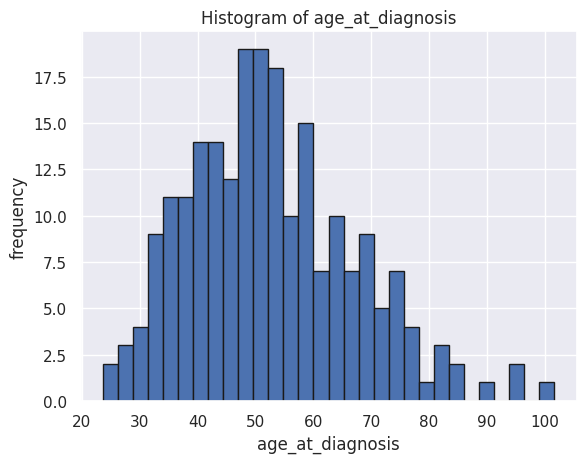

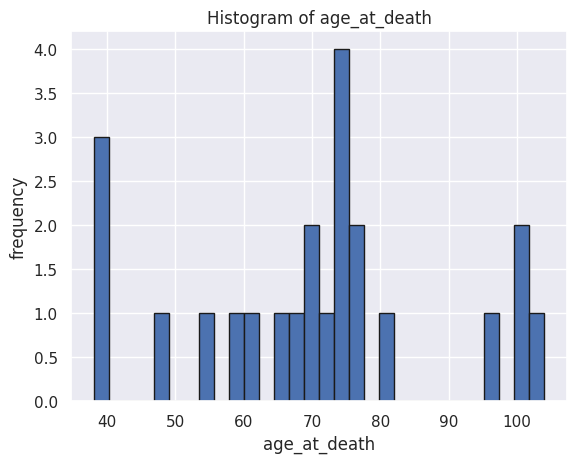

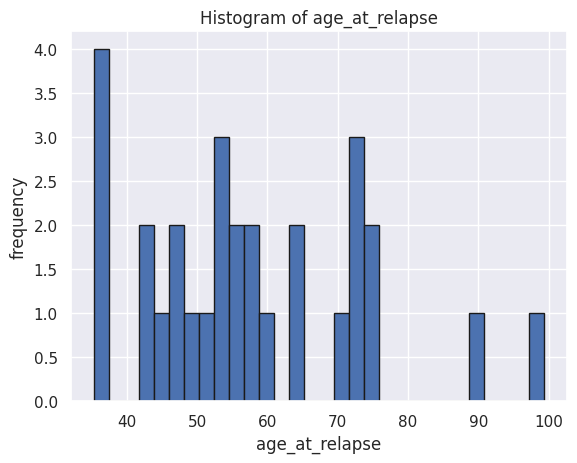

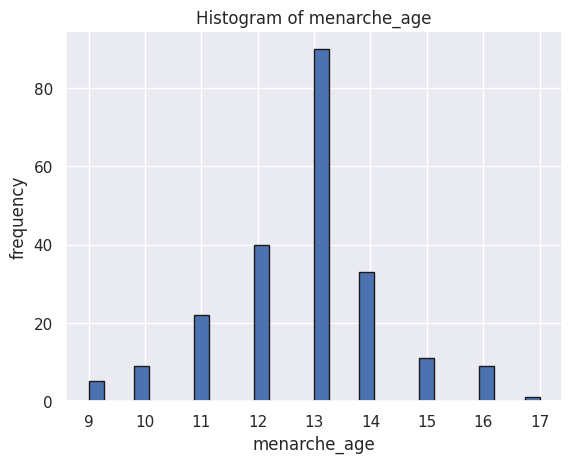

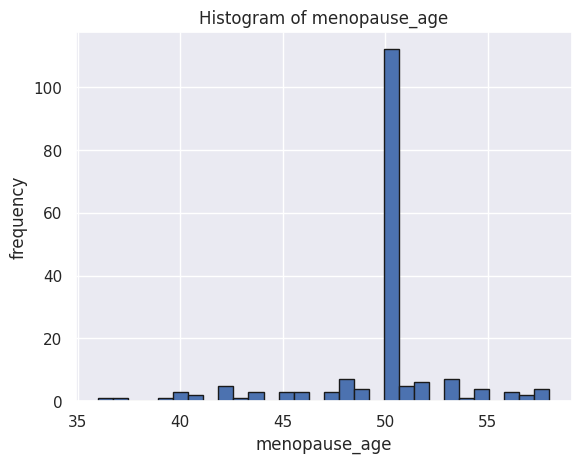

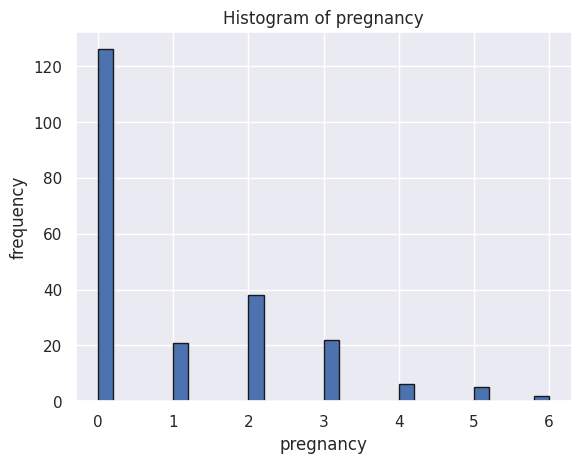

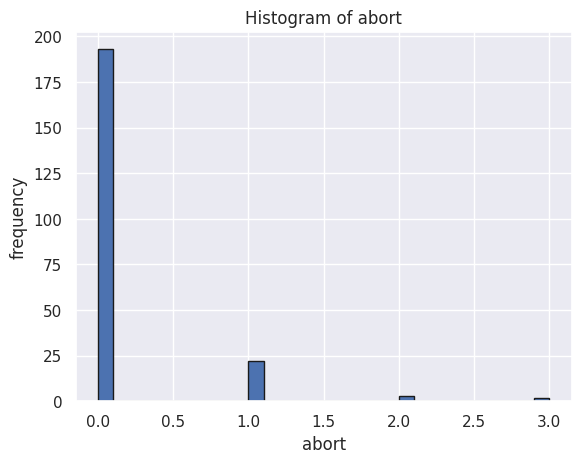

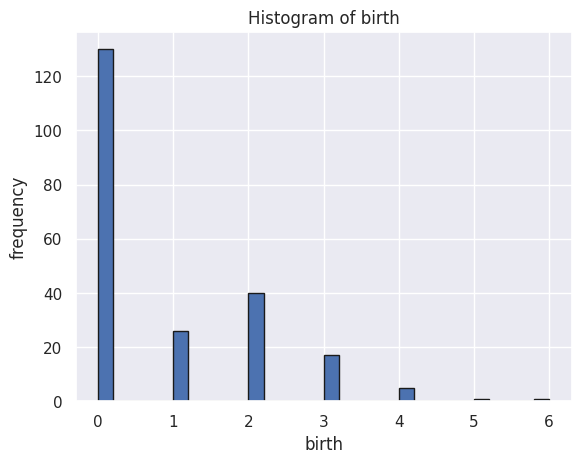

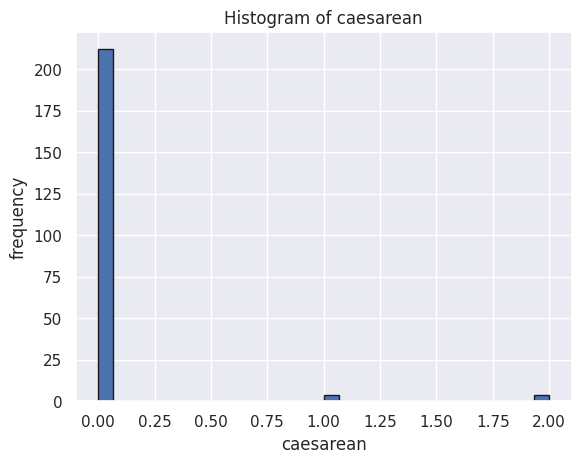

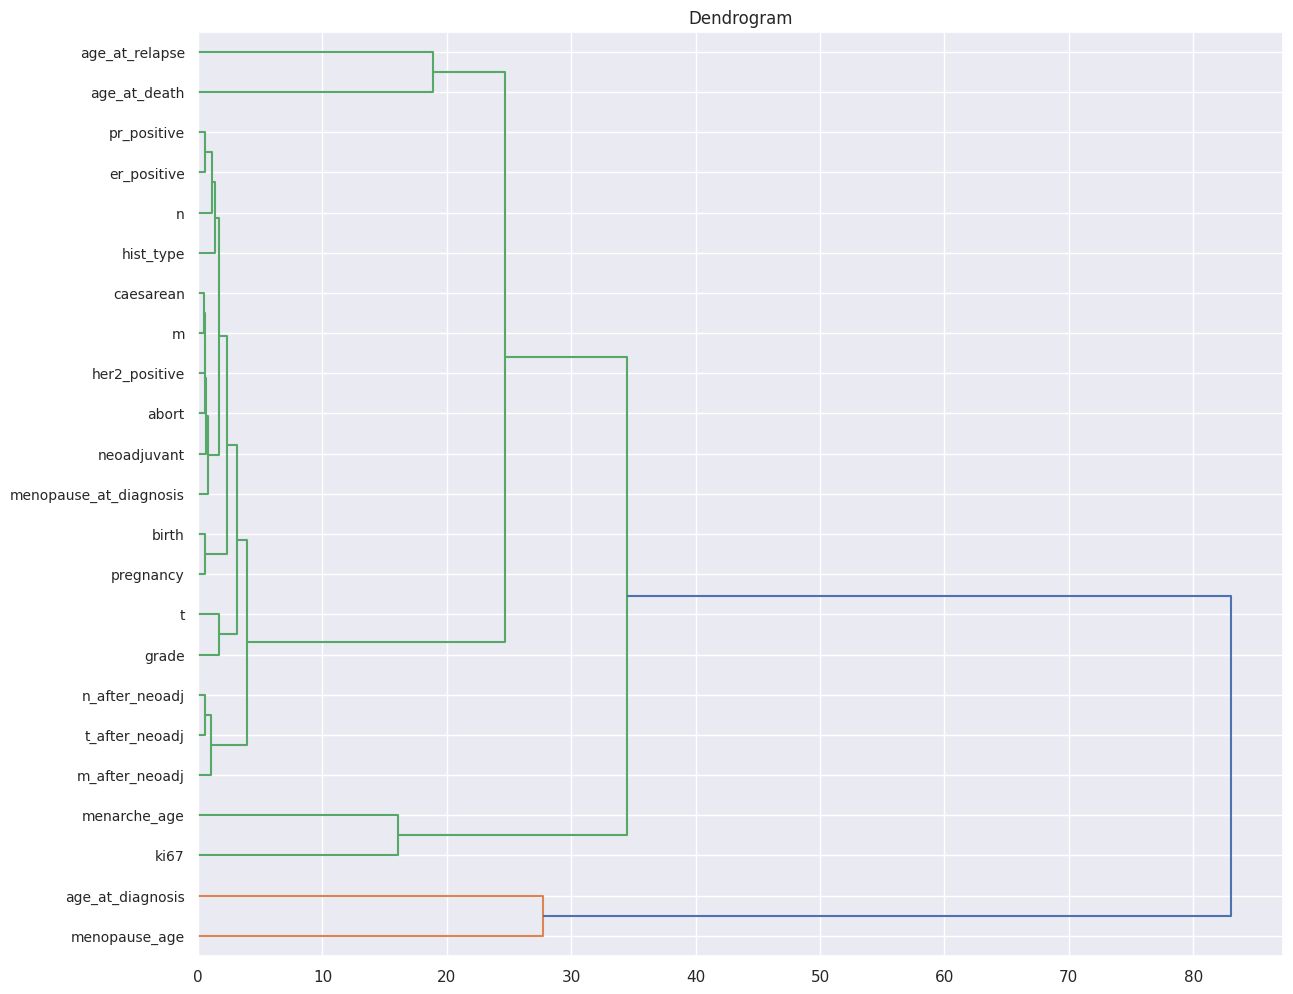

<ipython-input-37-b8e2334b1425>:68: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(skewness, color='blue')


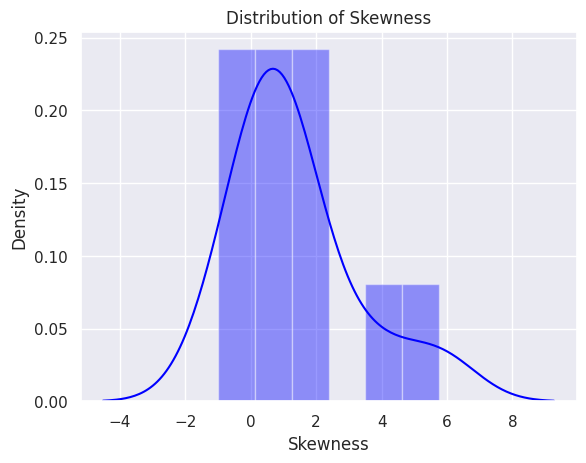

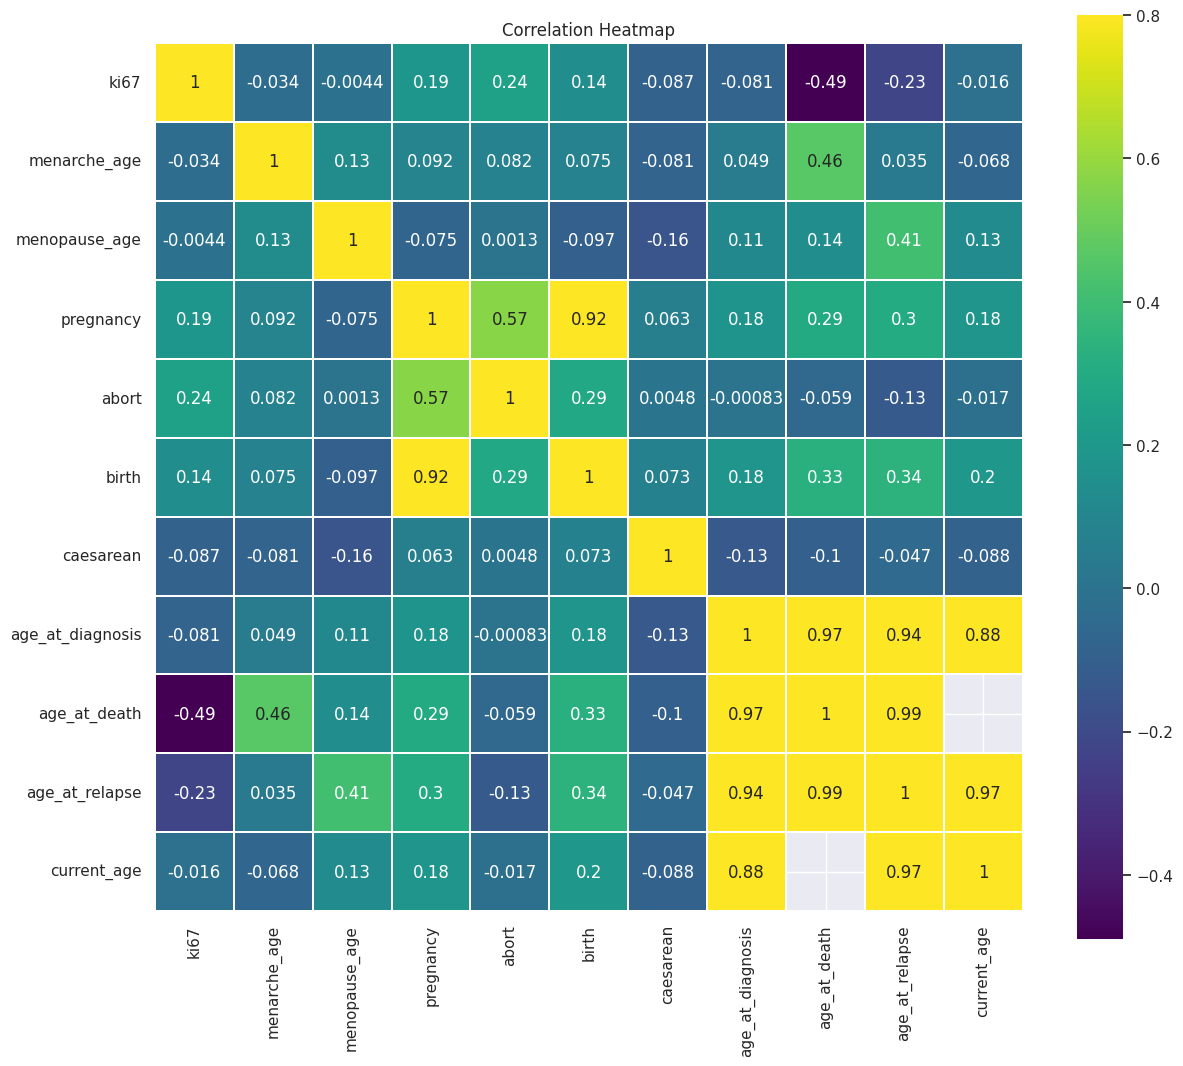

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


count    220.000000
mean      20.936364
std       16.403183
min        0.000000
25%       10.000000
50%       20.000000
75%       20.000000
max      100.000000
Name: ki67, dtype: float64


Text(0.5, 0, 'm')

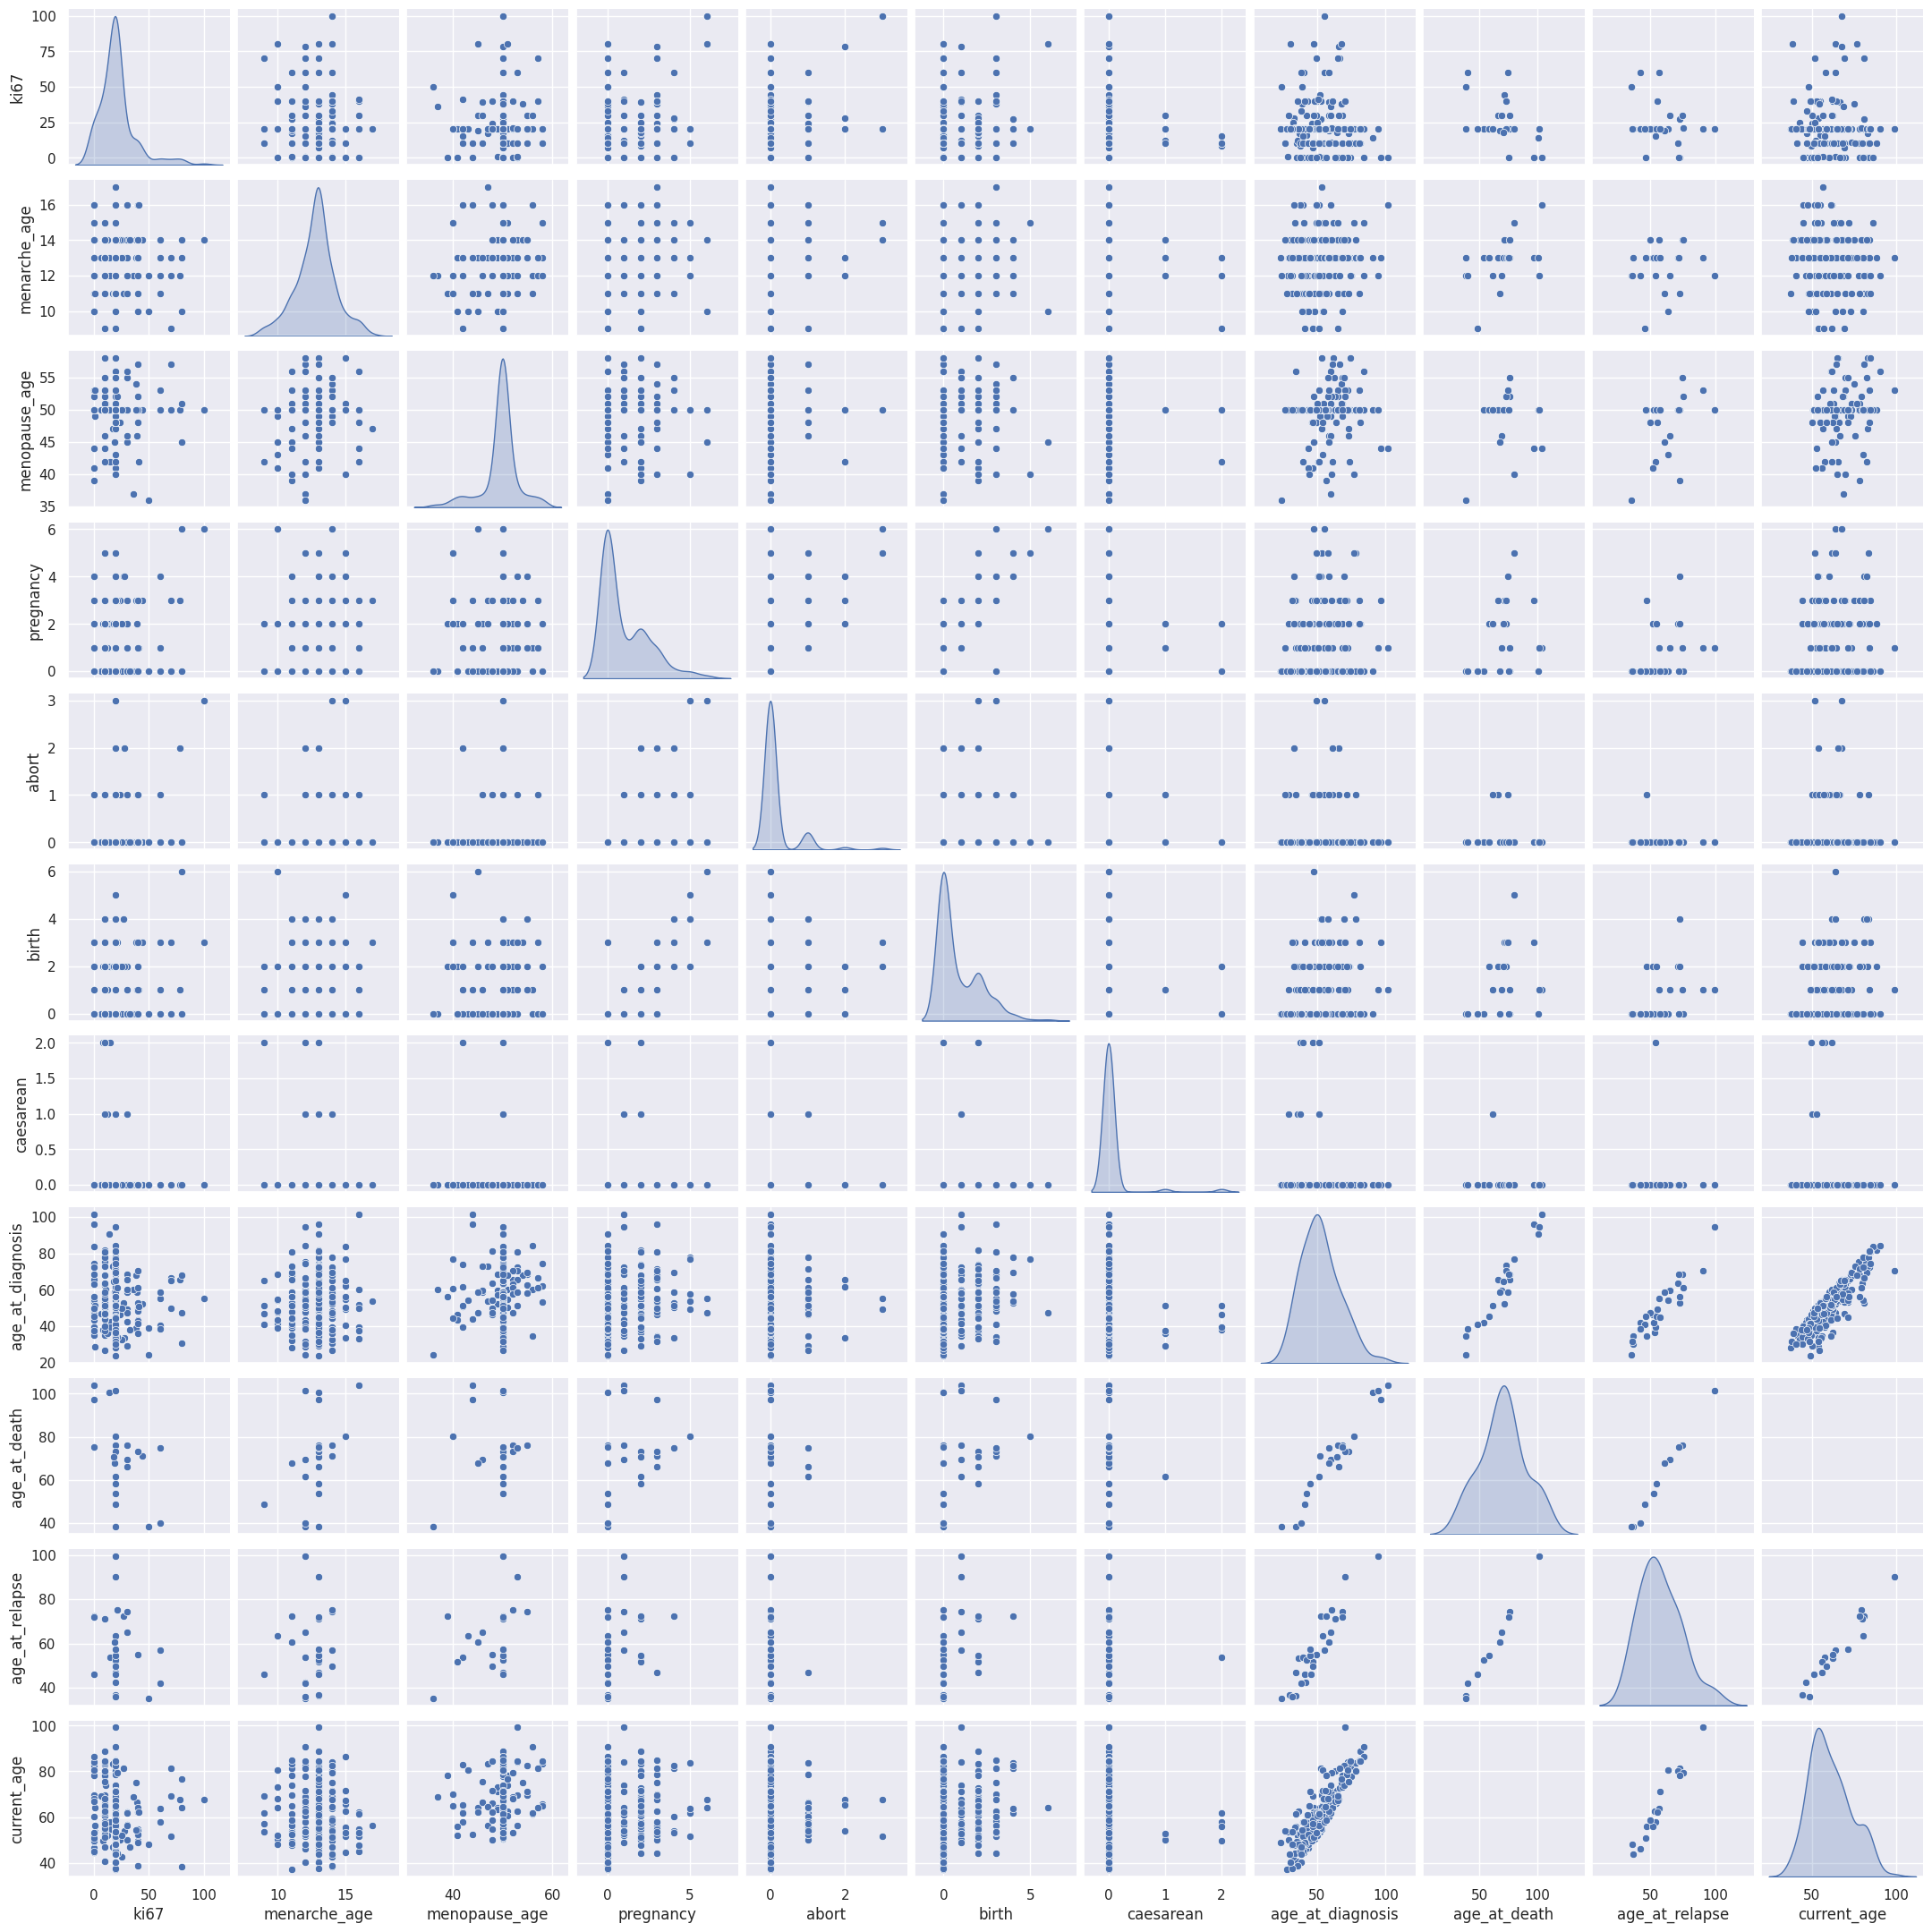

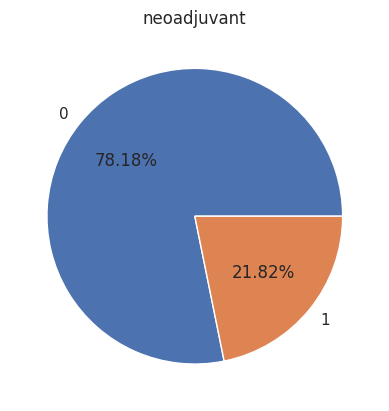

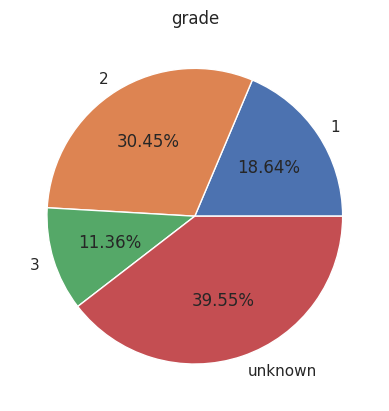

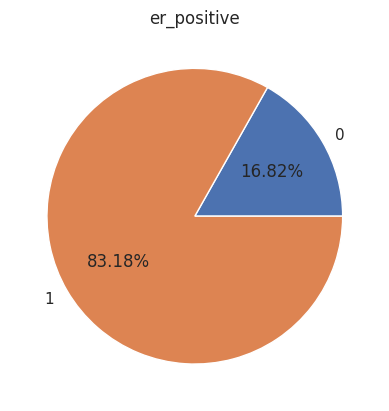

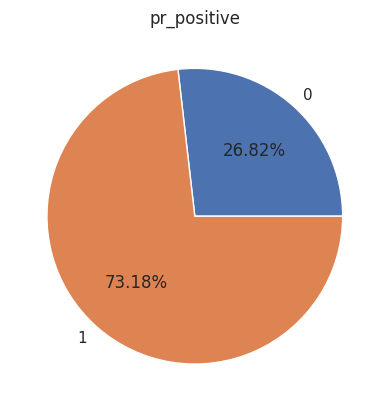

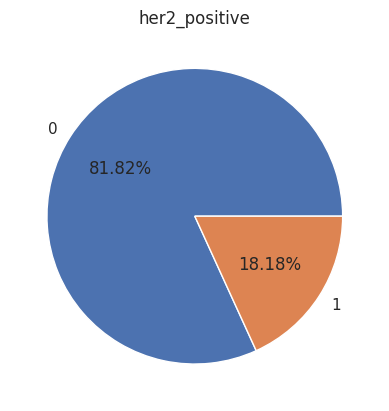

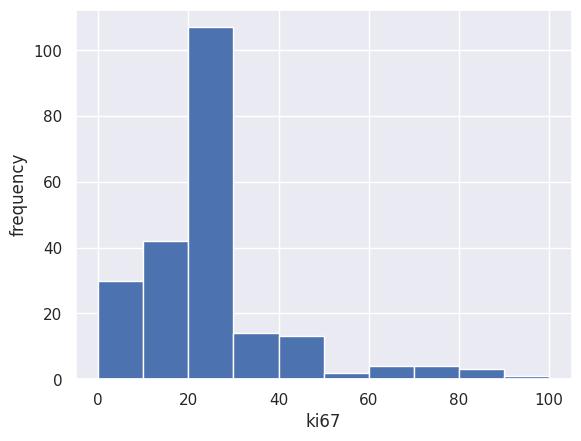

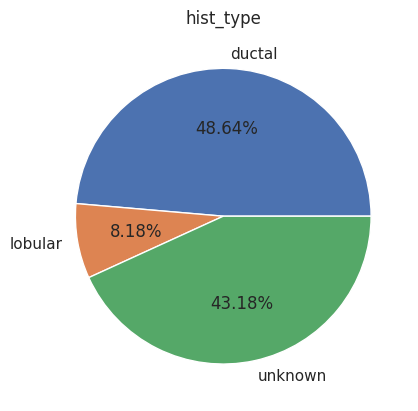

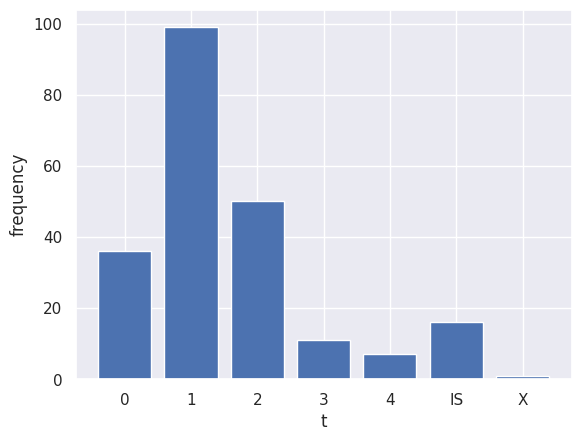

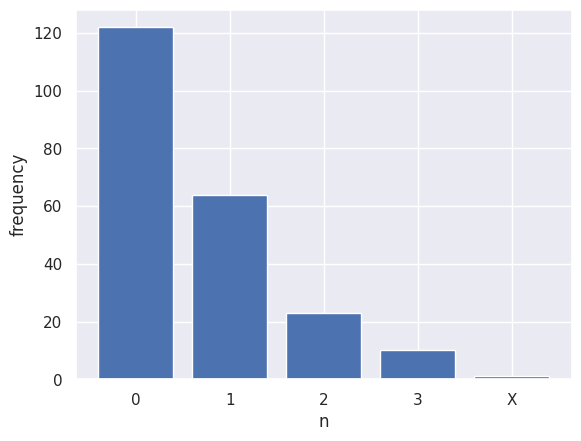

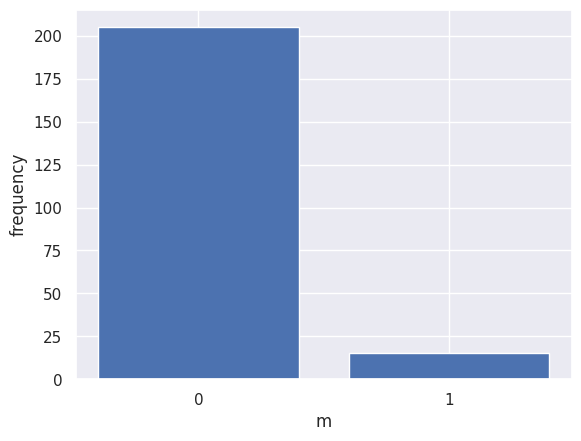

In [ ]:
#PART 7 UNIVERATE ANALYSIS

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np
from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram



# histogram of age
for age in ['age_at_diagnosis', 'age_at_death', 'age_at_relapse', 'menarche_age', 'menopause_age']:
    plt.figure()
    plt.hist(df_bcd[age].dropna(), bins=30, edgecolor='k')
    plt.xlabel(age)
    plt.ylabel('frequency')
    plt.title(f'Histogram of {age}')
plt.show()

# The age of the diagnosis is mainly around the interval 45 - 65 years
# For death and relapse, the frequency are not high so we can't evaluate the repartition
# Menarche age is not particular
# Menopause age is maybe biaised with the fill by the mean maybe (around 47)

# histogram of pregnancy

for preg in ['pregnancy', 'abort', 'birth', 'caesarean']:
    plt.figure()
    plt.hist(df_bcd[preg].dropna(), bins=30, edgecolor='k')
    plt.xlabel(preg)
    plt.ylabel('frequency')
    plt.title(f'Histogram of {preg}')
plt.show()

# The number of pregnancy is between 0 and 3 for the majority, which is
# not far from a nationnal mean of pregnancy in the occident countries
# Around 10% had an abortion, and more than 15% had one or two caesariean

# this encoding will be use for computing a dendrogram of the data

# categorical code encoding
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc_cols = [col for col in df_bcd.columns if (df_bcd[col].dtype == "object") or (df_bcd[col].dtype == "category")]
df_bcd_enc = df_bcd.copy()
df_bcd_enc[enc_cols] = enc.fit_transform(df_bcd[enc_cols])


numeric_cols = df_bcd_enc.select_dtypes(include=[np.number]).columns
df_bcd_enc = df_bcd_enc[numeric_cols]


cols = ['grade', 'er_positive', 'pr_positive', 'her2_positive', 'hist_type', 't', 'n', 'm', 'neoadjuvant',
        't_after_neoadj', 'n_after_neoadj', 'm_after_neoadj', 'ki67', 'menarche_age', 'menopause_at_diagnosis',
        'menopause_age', 'pregnancy', 'abort', 'birth', 'caesarean', 'age_at_diagnosis', 'age_at_death', 'age_at_relapse']

scaled_data = whiten(df_bcd_enc[cols].fillna(-1).to_numpy().transpose())
distance_matrix = linkage(scaled_data, method='ward', metric='euclidean')

plt.figure(figsize=(14, 12))
dendrogram(distance_matrix, labels=df_bcd_enc[cols].columns, orientation="right")
plt.title('Dendrogram')
plt.show()

numeric_cols = df_bcd.select_dtypes(include=[np.number]).columns
skewness = df_bcd[numeric_cols].skew()

plt.figure()
sns.distplot(skewness, color='blue')
plt.xlabel('Skewness')
plt.title('Distribution of Skewness')
plt.show()

# The dendrogram allows you to more fully correlate variable completion,
# revealing trends deeper than the pairwise ones visible in the correlation heatmap
# We can confirm the correlation of t n and m, birth, pregnancy and abort

# correlation heatmap
correlation = df_bcd[numeric_cols].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, vmax=.8, linewidths=0.01, square=True, annot=True, cmap='viridis',
            linecolor="white", xticklabels=correlation.columns, yticklabels=correlation.columns)
plt.title('Correlation Heatmap')
plt.show()

# The correlation heatmap measures nullity correlation: how strongly
# the presence or absence of one variable affects the presence of another
# Pregnancy abort and birth are related (normal)
# also t n and m, and same with t n and m after neoadj
# Age negatively related with age at death (normal)

# pair plot
sns.set()
columns = df_bcd.columns
sns.pairplot(df_bcd[columns],size = 2 ,kind ='scatter',diag_kind='kde')
# Ages are linearly related (as we saw before)
# Shape of the variables are not a lot skewed
# Several are binary variables

# binary variables
# neoadjuvant
d = df_bcd.groupby(['neoadjuvant']).count().ehr
plt.figure()
plt.pie(d, labels=d.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title('neoadjuvant')
# Less then 1/4 of patient received neoadjuvant chemotherapy

# grade
d = df_bcd.groupby(['grade']).count().ehr
plt.figure()
plt.pie(d, labels=d.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title('grade')
# Half of the patients are in grade 2 and 1/3 in grade 1

# er_positive
d = df_bcd.groupby(['er_positive']).count().ehr
plt.figure()
plt.pie(d, labels=d.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title('er_positive')
# 80% of the tumor has estrogen receptors

# pr_positive
d = df_bcd.groupby(['pr_positive']).count().ehr
plt.figure()
plt.pie(d, labels=d.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title('pr_positive')
# 70% of the tumor has progesteron receptors

# her2_positive
d = df_bcd.groupby(['her2_positive']).count().ehr
plt.figure()
plt.pie(d, labels=d.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title('her2_positive')
# near 80% of the tumor doesn't have a HER2 protein overexpression

# Ki67
plt.figure()
plt.hist(df_bcd.ki67)
plt.ylabel('frequency')
plt.xlabel('ki67')
print(df_bcd.ki67.describe())
# The percentage for proliferation indicated by the column ki67 is distributed
# mainly between 0% and 30%. The mean is 21%, with a standard deviation of 19 which
# indicates that the distribution is not concentrated around the mean value.
# We can notice that more than 75% of the values are under a ki67 of 30%.

# histological type
d = df_bcd.groupby(['hist_type']).count().ehr
plt.figure()
plt.pie(d, labels=d.index, autopct = lambda x: str(round(x, 2)) + '%',)
plt.title('hist_type')
# The histological type of the cancer of the patient is ductal for 86%
# of the patient, and lobular for the others.

# t
d = df_bcd[['ehr', 't']].groupby(['t']).count().ehr
plt.figure()
plt.bar(d.index, d)
plt.ylabel('frequency')
plt.xlabel('t')
# Fot T classification, 1 is the most frequent value, then it is 2.
# The values 4 and X are not a lotpresent.

# n
d = df_bcd[['ehr', 'n']].groupby(['n']).count().ehr
plt.figure()
plt.bar(d.index, d)
plt.ylabel('frequency')
plt.xlabel('n')
# For N, it is 0 then 1 that are the most frequent.

# m
d = df_bcd[['ehr', 'm']].groupby(['m']).count().ehr
plt.figure()
plt.bar(d.index, d)
plt.ylabel('frequency')
plt.xlabel('m')
# For M, the value is mainly 0.


<Axes: xlabel='pregnancy', ylabel='count'>

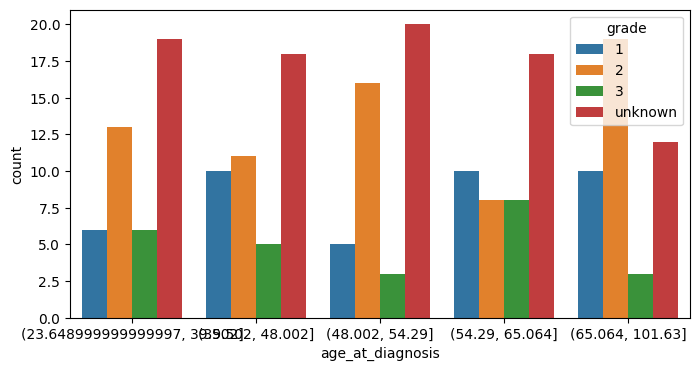

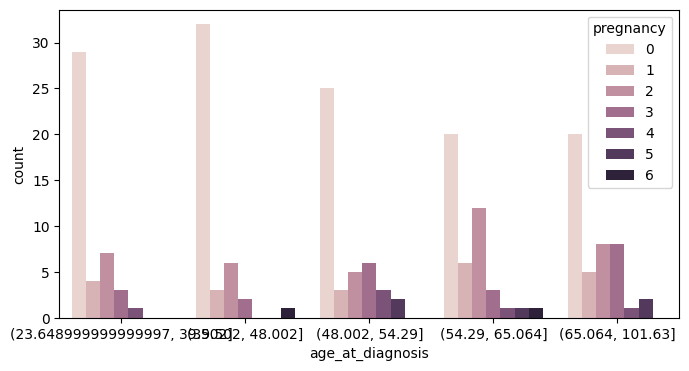

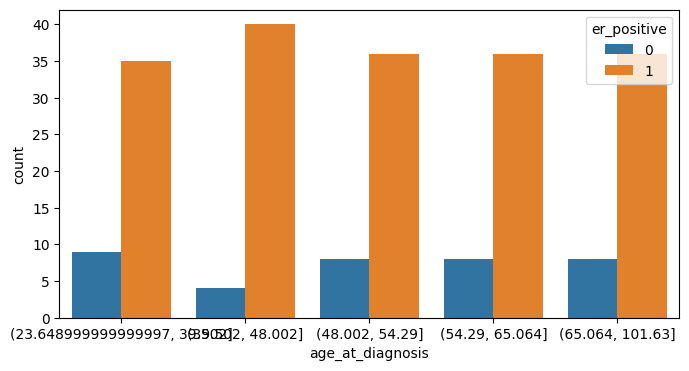

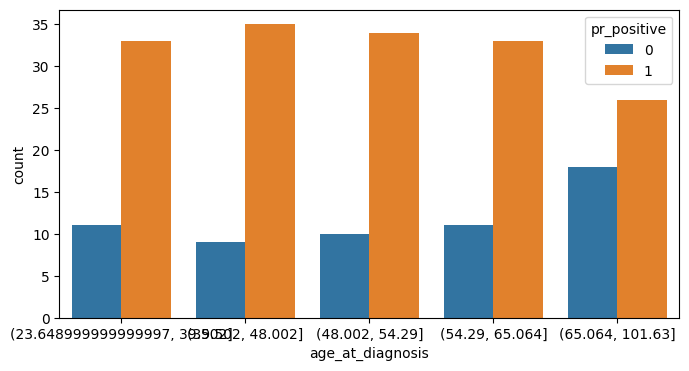

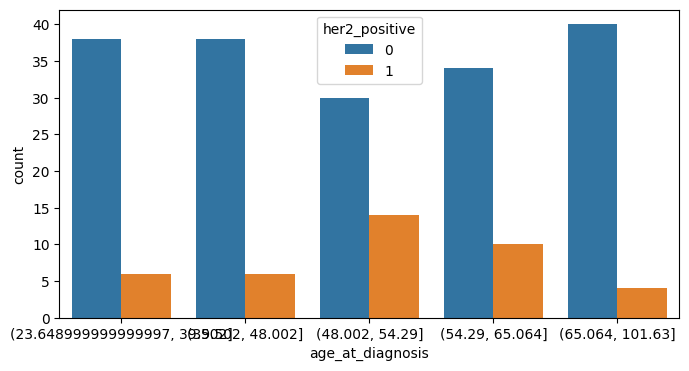

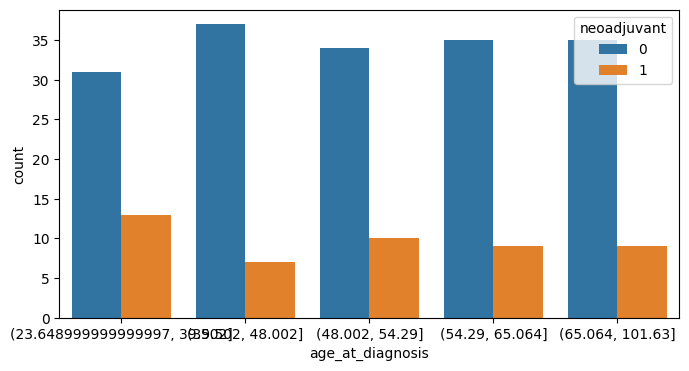

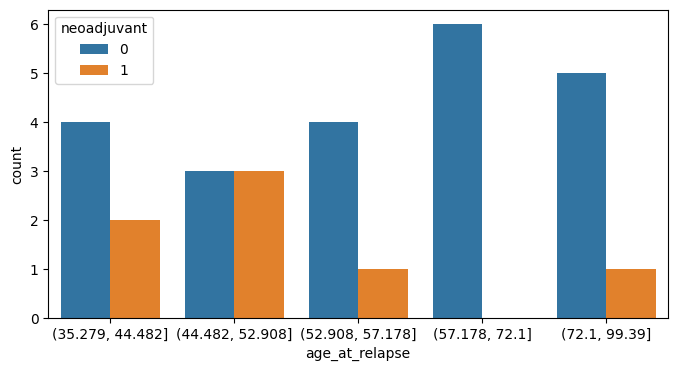

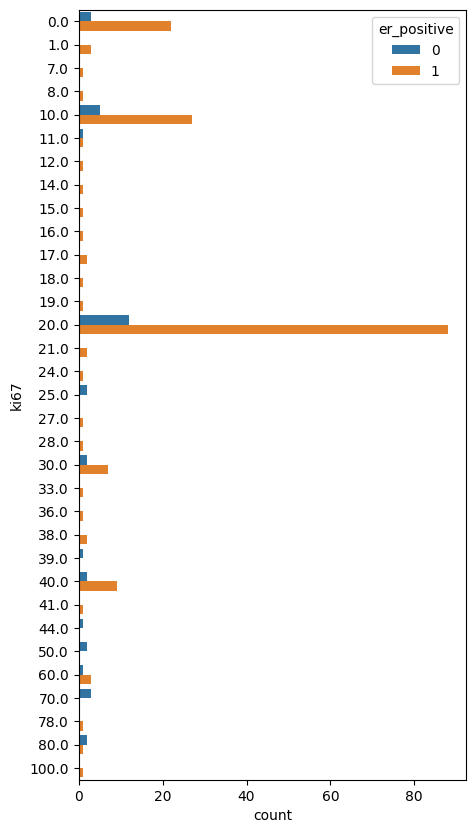

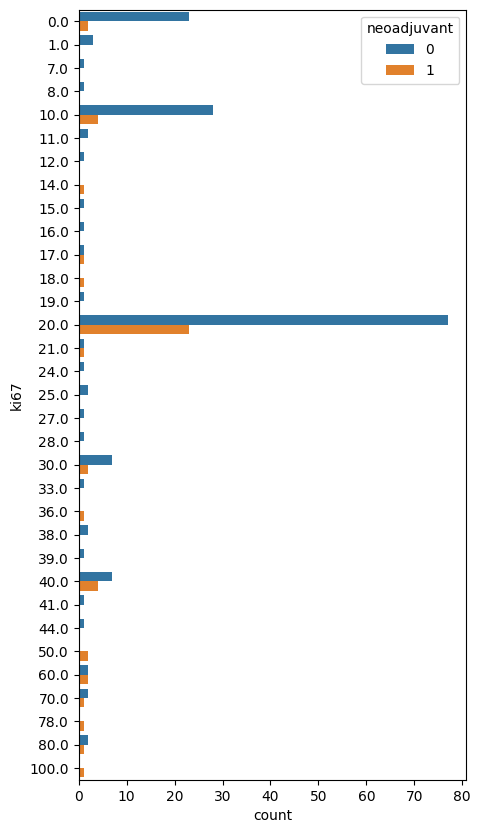

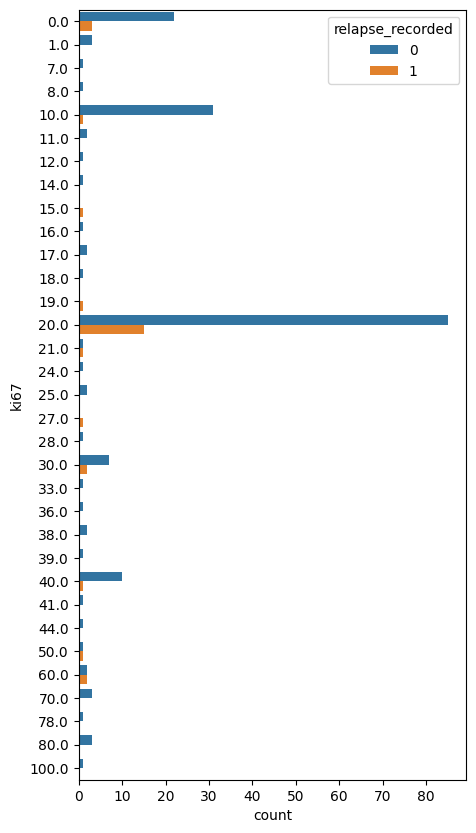

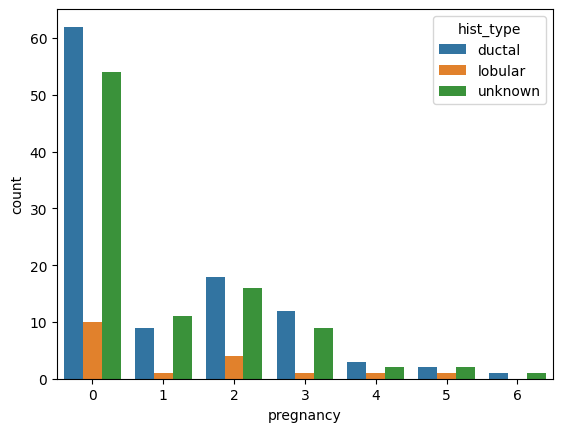

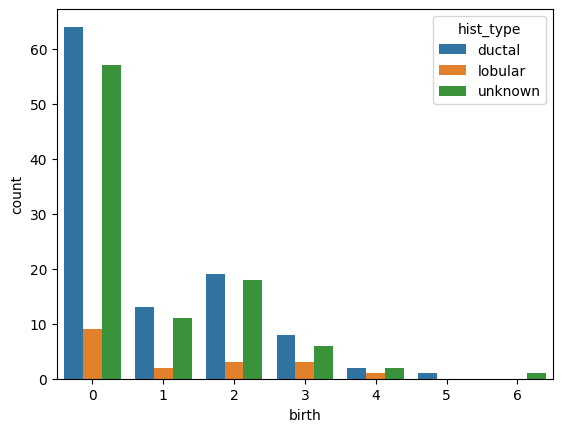

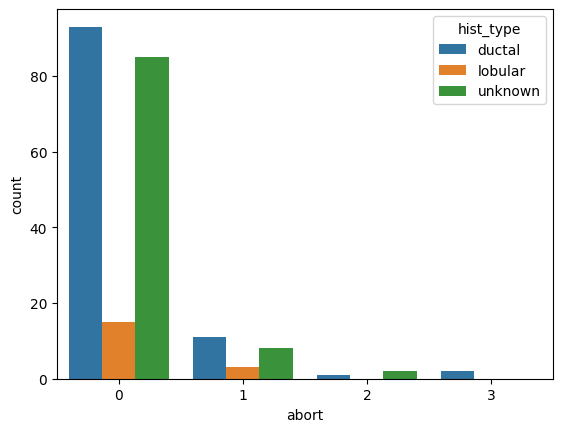

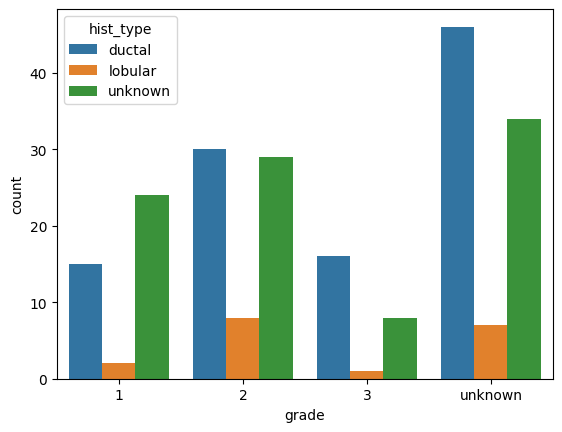

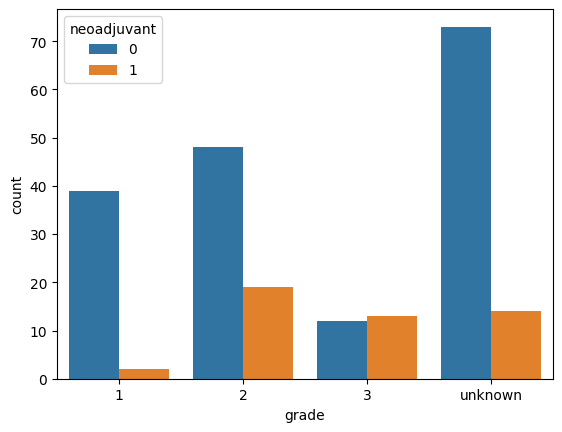

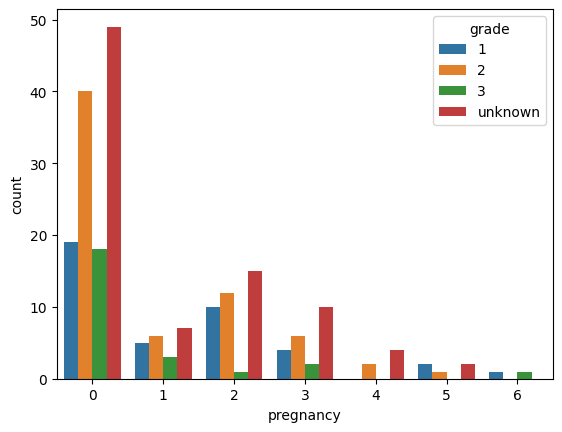

In [ ]:
## PART 7: ANALYSIS (2/2)
##### BIVARIATE ANALYSIS #####

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_diagnosis'],5), hue=df_bcd['grade'])
# We can observe alarge majority of grade 2 for the oldest patients.
# The youngest quartile of ages contains more grade 3 than the other quartiles.
# We can observe more grade 1 for the ages 40-49 and 55-65

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_diagnosis'],5), hue=df_bcd['pregnancy'])
# For the pregnancy, for all ages, patients have mostly never been pregnant.
# For the ages 55-65, there are as many patients that have never been pregnant
# than patients with two pregnancies.
# For the others quartiles of age, there are less than 10 patients that have been
# pregnant at least one time.

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_diagnosis'],5), hue=df_bcd['er_positive'])

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_diagnosis'],5), hue=df_bcd['pr_positive'])

# The age at diagnosis desn't seem to be related to estrogen receptors or
# progesteron receptors

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_diagnosis'],5), hue=df_bcd['her2_positive'])
# We can observe a little difference for the middle quartile of age, where there
# are more patients with HER2 protein overexpression

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_diagnosis'],5), hue=df_bcd['neoadjuvant'])
# The age of diagnosis doesn't seem related with the neoadjuvant chemotherapy,
# the distribution is the same

plt.figure(figsize=(8,4))
sns.countplot(x=pd.qcut(df_bcd['age_at_relapse'],5), hue=df_bcd['neoadjuvant'])
# for the age of relapse, we can observe that for young ages, more patients have a
# neoadjuvant chemotherapy than for older ages (more than 53)


plt.figure(figsize=(5,10))
sns.countplot(y=df_bcd['ki67'], hue=df_bcd['er_positive'])
plt.xticks(rotation='horizontal')
# The percentage for proliferation can be related to estrogen receptors
# because we observe some pic at multiples of ten

plt.figure(figsize=(5,10))
sns.countplot(y=df_bcd['ki67'], hue=df_bcd['neoadjuvant'])
plt.xticks(rotation='horizontal')
# The schema is the same as for neoadjuvant

plt.figure(figsize=(5,10))
sns.countplot(y=df_bcd['ki67'], hue=df_bcd['relapse_recorded'])
plt.xticks(rotation='horizontal')
# The schema shows pic at multiple of ten for the not presence of relapse



plt.figure()
sns.countplot(x=df_bcd['pregnancy'], hue=df_bcd['hist_type'])
# We can observe that the proportion of patients with a ductal histological type of
# the cancer is really higher for patients with 0 pregnancy.

plt.figure()
sns.countplot(x=df_bcd['birth'], hue=df_bcd['hist_type'])

plt.figure()
sns.countplot(x=df_bcd['abort'], hue=df_bcd['hist_type'])
# figures are similar with the one with pregnancy

plt.figure()
sns.countplot(x=df_bcd['grade'], hue=df_bcd['hist_type'])
# the proportion of lobular type of cancer if higher for the grade 2

plt.figure()
sns.countplot(x=df_bcd['grade'], hue=df_bcd['neoadjuvant'])
# neoadjuvant is more given to patients with higher grades

plt.figure()
sns.countplot(x=df_bcd['pregnancy'], hue=df_bcd['grade'])
# the proportion on grade 2 is higher for patients with 0 pregnancy